[![Colab Badge Link](https://img.shields.io/badge/open-in%20colab-blue)](https://colab.research.google.com/github/Glasgow-AI4BioMed/tutorials/blob/main/training_a_biencoder_end_to_end_for_entity_linking.ipynb)

# Training a Bi-encoder End-to-End for Entity Linking

This notebook goes over training a transformer to generate appropriate embeddings for an entity linking task. This is known as a bi-encoder (or siamese networks) approach where two text inputs are fed through the same transformer network and the resulting vector is compared. We want to train a transformer where vectors for texts that refer to the same entity are similar.

## Accessing a GPU

This tutorial benefits from a GPU. If you're running it in Colab, you can get one through selecting `Edit`, then `Notebook Settings` and picking an appropriate GPU options.

## Overview

The overall idea of the architecture is illustrated in the figure below. The text from two sources are encoded to vectors and their vectors are compared. The sources could be entity mentions and ontology text for entity linking or queries and documents for information retrieval. We want to train a transformer so that it gives us effective vectors for this task.

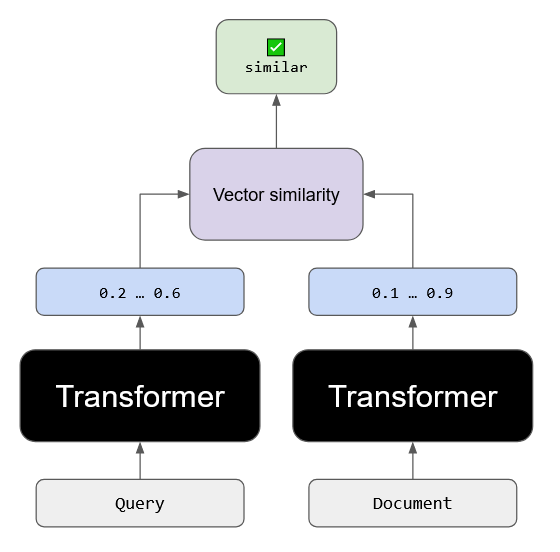

This architecture contrasts with a cross-encoder where the two documents are encoded by a single Transformer model. A cross-encoder becomes very inefficient when there are many possible pairs of documents to encode. The bi-encoder model avoids the problem of all possible pairs.

### Ranking or classification

Comparing two input texts can be framed as a ranking or a classification task.

- **Classification:** Given two texts, are they similar - Yes or No?
  - This would then be evaluated with standard classification metrics like accuracy, F1, etc
- **Ranking:** Given one input text, give an ordered list of similar texts
  - This would be evaluated with ranking metrics like hits @ K, NDCG, etc

To train a bi-encoder model, we need to work with pairs of documents so it will initially look like a classification problem. It can be later used as a ranker by running against all possible pairs, but for the sake of this Colab, we'll focus on the classification framing.

## Data Source

We're going to use texts from a biomedical ontology that provides a list of diseases with their names and other details. We'll create matches/mismatches using their known aliases and misspellings.

The dataset is the [Disease Ontology](https://disease-ontology.org/). Let's download it:

In [ ]:
#!wget -O doid.obo https://purl.obolibrary.org/obo/doid.obo

We've downloaded the [OBO version](https://en.wikipedia.org/wiki/OBO_Foundry) of the ontology. We'll use the [pronto library](https://pronto.readthedocs.io/en/stable/) to process it:

In [ ]:
#!pip install pronto

It can be loaded as such:

In [ ]:
import pronto

ont = pronto.Ontology('doid.obo')

We'll pull out just the identifiers, names and aliases for non-obsolete terms:

In [ ]:
disease_ontology = []

for term in ont.terms():
  if not term.obsolete:

    aliases = [ term.name ]
    for s in term.synonyms:
      if s.scope == 'EXACT':
        aliases.append(s.description.lower())
    aliases = sorted(set(aliases))

    disease_ontology.append( {'id':term.id, 'name':term.name, 'aliases':aliases} )

len(disease_ontology)

You can see one example from the ontology below:

In [ ]:
disease_ontology[0]

## Making a dataset

We're going to create a dataset of pairs of texts from the Disease Ontology list of names and aliases. Let's deal with the positive cases first:

Some of the pairs will be for two texts that should match the same disease. We'll make half of them using the provided aliases in the Disease Ontology (where we pick two names for the same disease). For the other half, we'll introduce some spelling mistakes into an alias so that slight misspellings should still match to the same disease.

Let's get the [textnoisr library](https://github.com/preligens-lab/textnoisr) that can add spelling mistakes:


In [ ]:
#!pip install textnoisr

We can add some spelling mistakes to input text as below:

In [ ]:
from textnoisr import noise
text = "The duck-billed platypus (Ornithorhynchus anatinus) is a small mammal."
augmenter = noise.CharNoiseAugmenter(noise_level=0.1)
print(augmenter.add_noise(text))

Now let's get all possible pairs of names/aliases that the Disease Ontology tells us refer to the same disease. We'll use [itertools combinations](https://docs.python.org/3/library/itertools.html#itertools.combinations) for this.

In [ ]:
import itertools

all_alias_pairs = [ (a,b) for x in disease_ontology for a,b in itertools.combinations(x['aliases'], 2)]
len(all_alias_pairs)

That's a lot of pairs. Let's see what one looks like:

In [ ]:
all_alias_pairs[0]

We won't use all the pairs but create half of our dataset with a random sample from them:

In [ ]:
import random
random.seed(42)

N_pos = 10000

pos_pairs = random.sample(all_alias_pairs, N_pos//2)

Now let's create the other half of the positive examples. We'll pick a random disease and its alias, and add some spelling mistakes to make its pair:

In [ ]:
for _ in range(N_pos//2):
  x = random.choice(disease_ontology)
  alias = random.choice(x['aliases'])

  augmenter = noise.CharNoiseAugmenter(noise_level=0.1)

  misspelled_alias = augmenter.add_noise(x['name'])

  pos_pairs.append( (alias, misspelled_alias) )

len(pos_pairs)

That's us made the two halves of our positive set. Now it's time to create some negative pairs. These are two texts that are not referring to the same entity.

One option is to pick two random disease names for two different diseases from the Disease Ontology. We want to use similar diseases to those that already appear in our positive examples (so that the positive and negative examples look alike).

Let's get all the aliases that were actually used in the positive set:

In [ ]:
aliases_in_pos_pairs = [ a for a,b in pos_pairs ] + [ b for a,b in pos_pairs ]
aliases_in_pos_pairs = sorted(set(aliases_in_pos_pairs))
len(aliases_in_pos_pairs)

Now pick two random aliases from this list, make sure they're not in our positive set (or already in the negative set). We keep doing that until we get the dataset size we want:

In [ ]:
N_neg = 10000

neg_pairs = set()

all_alias_pairs_set = set(all_alias_pairs)

while len(neg_pairs) < N_neg:

  alias1, alias2 = random.sample(aliases_in_pos_pairs, 2)

  if (alias1, alias2) in all_alias_pairs_set or (alias2, alias1) in all_alias_pairs_set:
    continue
  elif (alias1, alias2) in neg_pairs or (alias2, alias1) in neg_pairs:
    continue
  else:
    neg_pairs.add( (alias1, alias2) )

len(neg_pairs)

We'll turn them from tuples into dictionaries with nice labels and a boolean label of whether they are positive or negative pairs:

In [ ]:
pairs = [ {'text1':a, 'text2':b, 'label':True} for a,b in pos_pairs ] + [ {'text1':a, 'text2':b, 'label':False} for a,b in neg_pairs ]

Now we'll split our dataset into training, validation and test splits:

In [ ]:
from sklearn.model_selection import train_test_split

train_pairs, valtest_pairs = train_test_split(pairs, train_size=0.6, random_state=43)
val_pairs, test_pairs = train_test_split(valtest_pairs, train_size=0.5, random_state=43)

len(train_pairs), len(val_pairs), len(test_pairs)

## The Bi-encoder

The bi-encoder architecture involves passing both texts through a transformer and comparing the resulting vectors. We intend to train the transformer. First, let's go through the steps involved before wrapping it up.

The first thing is to get a transformer model with its tokenizer:

In [ ]:
from transformers import AutoModel, AutoTokenizer

model_name = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext'

model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

While it trains, we'll work with small batches of data. Let's make one to demonstrate:

In [ ]:
batch = train_pairs[:8]
batch

We'll want to tokenize the texts for each batch:

In [ ]:
tokenized1 = tokenizer( [ x['text1'] for x in batch ], max_length=512, padding=True, truncation=True, return_tensors='pt' )
tokenized2 = tokenizer( [ x['text2'] for x in batch ], max_length=512, padding=True, truncation=True, return_tensors='pt' )

Then pass the first text through the transformer:

In [ ]:
outputs1 = model( **tokenized1 )

It gives us context vectors for every token of the eight samples in the batch:

In [ ]:
outputs1.last_hidden_state.shape

We only want the first vector to represent each of the samples (which is the [CLS] vector):

In [ ]:
cls_vectors1 = outputs1.last_hidden_state[:,0,:]
cls_vectors1.shape

And we can do the same for the second text in each sample:

In [ ]:
outputs2 = model( **tokenized2 )
cls_vectors2 = outputs2.last_hidden_state[:,0,:]
cls_vectors2.shape

We now have vectors for both texts for all eight samples. We want to compare each pair. The main options are cosine similarity or dot-product. We'll use dot-product in this tutorial:

In [ ]:
dotproducts = (cls_vectors1 * cls_vectors2).sum(axis=1)
dotproducts.shape

So we have a score for each of our eight pairs. What do those scores look like?

In [ ]:
dotproducts

Hmm, we'd really like negative pairs to have negative numbers, and positive pairs to have positive numbers.

### The Loss Function

To train it, we'll need to create a loss function that calculates the error between our known labels and the outputted scores. First, create a tensor with our known labels:

In [ ]:
import torch

labels = torch.tensor([ float(x['label']) for x in batch ])
labels

And set up the [BCEWithLogitsLoss function](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) as the loss function. We use that as it is a binary classification problem and the scores are unbounded (i.e. we've not applied something like a sigmoid).

In [ ]:
import torch.nn as nn

loss_func = torch.nn.BCEWithLogitsLoss()
loss_func(dotproducts, labels)

There are other options for loss functions that could work for this problem (and may be better). For instance, classification tasks can also use [CrossEntropyLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Or a margin loss approach could be used to explicitly push for a margin between scores for positive and negative pairs. These are all essentially ways of doing contrastive learning.

We'll stick with a BCEWithLogitsLoss for the simplicity of working with a single pair at a time and aiming for positive scores for positive pairs and negative scores for negative pairs.

## Training the Bi-encoder

Now we get to actually training the transformer so that the scores match better with our goal.

First we'll set up some hyperparameters that happen to work well for the generated dataset. Ideally, some hyperparameter tuning would be done to see if the performance can be improved using the training and validation sets.

In [ ]:
batch_size = 8
num_epochs = 3
learning_rate = 1e-5

Now we create the optimizer that is going to do the work of updating the transformer as we show it training examples:

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Let's check if there is a GPU:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

And move the model to the appropriate device:

In [ ]:
model = model.to(device)

And now is the big training loop. Notably, we do our own batching using [more_itertools's chunked function](https://more-itertools.readthedocs.io/en/stable/api.html#more_itertools.chunked) and tokenize each batch each time. For optimal speed, it may be better to do the tokenization ahead of time and use a [PyTorch Data Loader](https://docs.pytorch.org/docs/stable/data.html). But for code simplicity, this may be cleaner. It also runs the validation data and calculate metrics on it as well.

On a Colab GPU, this will take ~10 minutes to train:

In [ ]:
from more_itertools import chunked
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

for epoch in range(num_epochs):

  model.train()
  train_loss = 0
  random.shuffle(train_pairs)
  train_batches = list(chunked(train_pairs, batch_size))
  train_predictions, train_labels = [], []

  for batch in tqdm(train_batches):
    optimizer.zero_grad()

    tokenized1 = tokenizer( [ x['text1'] for x in batch ], max_length=512, padding=True, truncation=True, return_tensors='pt' )
    outputs1 = model( input_ids=tokenized1['input_ids'].to(device), attention_mask=tokenized1['attention_mask'].to(device) )
    cls_vectors1 = outputs1.last_hidden_state[:,0,:]

    tokenized2 = tokenizer( [ x['text2'] for x in batch ], max_length=512, padding=True, truncation=True, return_tensors='pt' )
    outputs2 = model( input_ids=tokenized2['input_ids'].to(device), attention_mask=tokenized2['attention_mask'].to(device) )
    cls_vectors2 = outputs2.last_hidden_state[:,0,:]

    dotproducts = (cls_vectors1 * cls_vectors2).sum(axis=1)

    labels = torch.tensor([ float(x['label']) for x in batch ]).to(device)

    loss = loss_func(dotproducts, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    train_predictions += [ dotproduct > 0 for dotproduct in dotproducts.cpu().tolist() ]
    train_labels += [ x['label'] for x in batch ]

  model.eval()
  val_loss = 0
  val_batches = list(chunked(val_pairs, batch_size))
  val_predictions, val_labels = [], []

  with torch.no_grad():
    for batch in tqdm(val_batches):

      tokenized1 = tokenizer( [ x['text1'] for x in batch ], max_length=512, padding=True, truncation=True, return_tensors='pt' )
      outputs1 = model( input_ids=tokenized1['input_ids'].to(device), attention_mask=tokenized1['attention_mask'].to(device) )
      cls_vectors1 = outputs1.last_hidden_state[:,0,:]

      tokenized2 = tokenizer( [ x['text2'] for x in batch ], max_length=512, padding=True, truncation=True, return_tensors='pt' )
      outputs2 = model( input_ids=tokenized2['input_ids'].to(device), attention_mask=tokenized2['attention_mask'].to(device) )
      cls_vectors2 = outputs2.last_hidden_state[:,0,:]

      dotproducts = (cls_vectors1 * cls_vectors2).sum(axis=1)

      labels = torch.tensor([ float(x['label']) for x in batch ]).to(device)

      loss = loss_func(dotproducts, labels)

      val_loss += loss.item()

      val_predictions += [ dotproduct > 0 for dotproduct in dotproducts.cpu().tolist() ]
      val_labels += [ x['label'] for x in batch ]

  train_loss /= len(train_batches)
  val_loss /= len(val_batches)

  train_f1 = f1_score(train_labels, train_predictions, zero_division=0)
  val_f1 = f1_score(val_labels, val_predictions, zero_division=0)

  print(f"{epoch=} {train_loss=:.4f} {train_f1=:.4f} {val_loss=:.4f} {val_f1=:.4f}")

## Trying it out

Let's check if it's learned anything. We'll pull some data from the validation set:

In [ ]:
batch = val_pairs[:8]
batch

And run those through the tokenizer and model to get the CLS vectors of each text:

In [ ]:
tokenized1 = tokenizer( [ x['text1'] for x in batch ], max_length=512, padding=True, truncation=True, return_tensors='pt' )
outputs1 = model( input_ids=tokenized1['input_ids'].to(device), attention_mask=tokenized1['attention_mask'].to(device) )
cls_vectors1 = outputs1.last_hidden_state[:,0,:]

tokenized2 = tokenizer( [ x['text2'] for x in batch ], max_length=512, padding=True, truncation=True, return_tensors='pt' )
outputs2 = model( input_ids=tokenized2['input_ids'].to(device), attention_mask=tokenized2['attention_mask'].to(device) )
cls_vectors2 = outputs2.last_hidden_state[:,0,:]

Calculate the dot-products of corresponding vectors:

In [ ]:
dotproducts = (cls_vectors1 * cls_vectors2).sum(axis=1)
dotproducts

Let's pair the dot-products back up with the original text data. Hopefully the actually positive pairs typically have higher dot-products than the negative pairs:

In [ ]:
for dotproduct,sample in zip(dotproducts,batch):
  print(f"{dotproduct=:.4f} {sample=}")

# Extra Ideas

Here are some extra thoughts to consider:

- The dataset for an entity linking task is more typically a corpus of documents with mentions of entities mapped to knowledgebase identifiers (e.g. MedMentions). The positives are then the pairs of mentions and their corresponding knowledgebase entry. You'd then need to create negative pairs through some form of random sampling (and that's an interesting challenge).
- The inputs here are only the names of entities. The transformers could be trained to accept the sentences that contain a mention, or a name & definition of an entity from the knowledgebase.
- The loss function and training set up could be changed. It might perform better with a more explicit contrastive learning approach, e.g. using a margin loss. More hyperparameter tuning and the use of early stopping might squeeze more performance out.
- The actual setup for an entity linking problem is not as a pairwise classification task. It's a search task where you get the vectors for your input (i.e. a mention in a document) and all the entities in the relevant ontology and compare them. So deploying the model looks different from training it. And evaluating it in that set up would involve a different approach, and different metrics (e.g. accuracy@1, accuracy@10, etc)